In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Normalization transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Class labels
classes = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']


Using device: cuda


100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]


In [2]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 32→16
        x = self.pool(F.relu(self.conv2(x)))   # 16→8
        x = self.pool(F.relu(self.conv3(x)))   # 8→4
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
def train_model(model, train_loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")


In [5]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc


In [6]:
def plot_confusion_matrix(model, test_loader, title="Confusion Matrix"):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=False, cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return cm



Training ANN...
Epoch [1/7], Loss: 1.6584
Epoch [2/7], Loss: 1.4317
Epoch [3/7], Loss: 1.3096
Epoch [4/7], Loss: 1.2135
Epoch [5/7], Loss: 1.1282
Epoch [6/7], Loss: 1.0435
Epoch [7/7], Loss: 0.9630
Test Accuracy: 53.90%

Confusion Matrix for ANN:


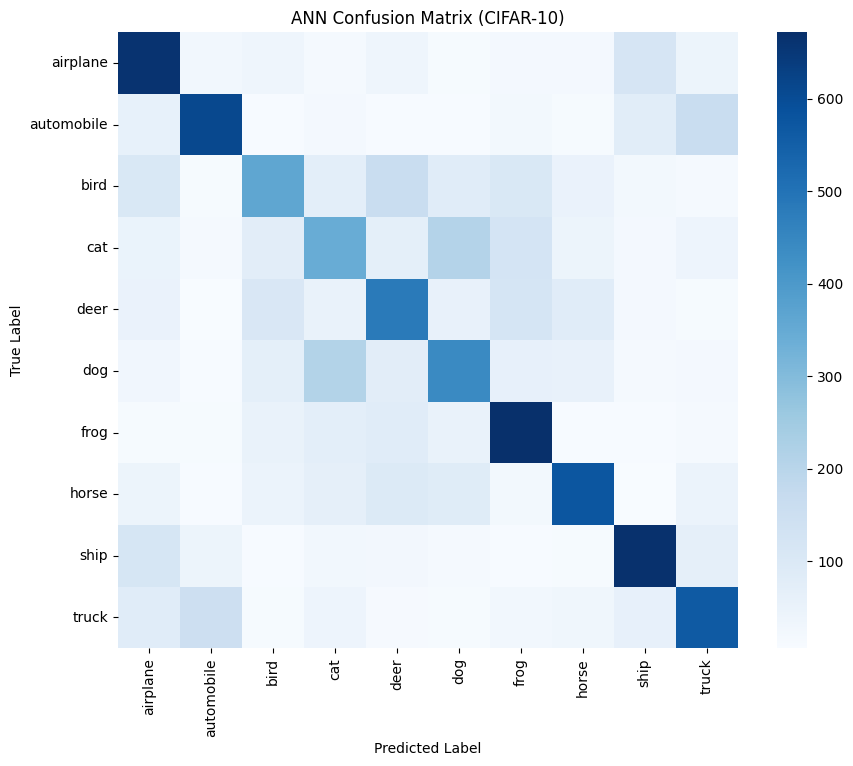

In [13]:
ann = ANN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ann.parameters(), lr=0.001)

print("\nTraining ANN...")
train_model(ann, train_loader, optimizer, criterion, epochs=7)
ann_acc = test_model(ann, test_loader)

print("\nConfusion Matrix for ANN:")
cm_ann = plot_confusion_matrix(ann, test_loader, title="ANN Confusion Matrix (CIFAR-10)")



Training CNN...
Epoch [1/15], Loss: 1.4609
Epoch [2/15], Loss: 1.0494
Epoch [3/15], Loss: 0.8574
Epoch [4/15], Loss: 0.7158
Epoch [5/15], Loss: 0.6206
Epoch [6/15], Loss: 0.5308
Epoch [7/15], Loss: 0.4407
Epoch [8/15], Loss: 0.3721
Epoch [9/15], Loss: 0.3005
Epoch [10/15], Loss: 0.2356
Epoch [11/15], Loss: 0.1821
Epoch [12/15], Loss: 0.1371
Epoch [13/15], Loss: 0.1022
Epoch [14/15], Loss: 0.0964
Epoch [15/15], Loss: 0.0917
Test Accuracy: 74.92%

Confusion Matrix for CNN:


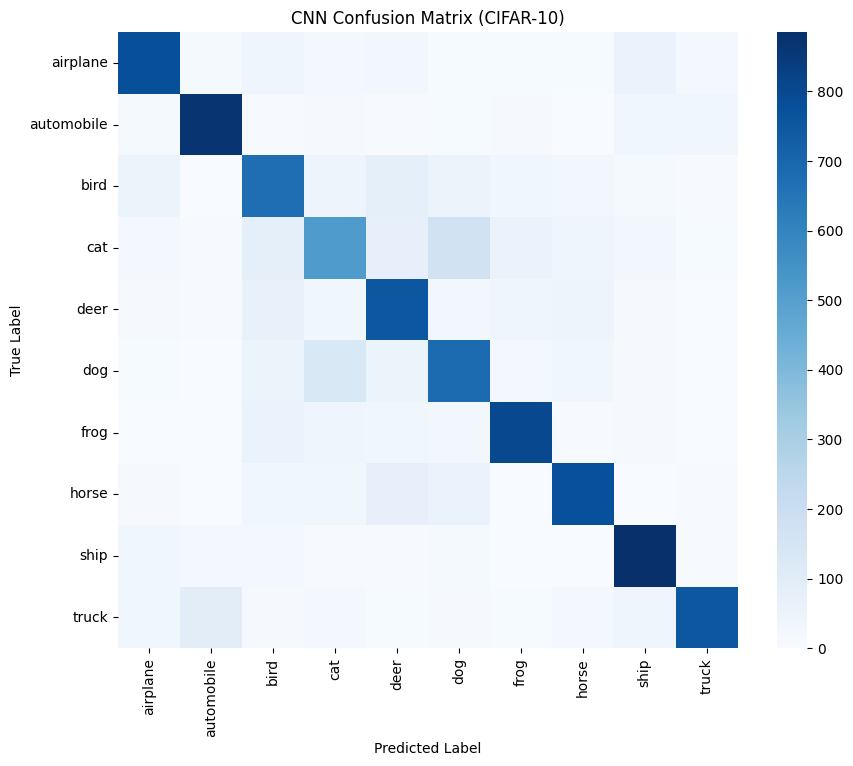

In [14]:
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

print("\nTraining CNN...")
train_model(cnn, train_loader, optimizer, criterion, epochs=15)
cnn_acc = test_model(cnn, test_loader)

print("\nConfusion Matrix for CNN:")
cm_cnn = plot_confusion_matrix(cnn, test_loader, title="CNN Confusion Matrix (CIFAR-10)")


In [15]:
print("\n===== Summary =====")
print(f"ANN Test Accuracy: {ann_acc:.2f}%")
print(f"CNN Test Accuracy: {cnn_acc:.2f}%")



===== Summary =====
ANN Test Accuracy: 53.90%
CNN Test Accuracy: 74.92%


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_and_print_confusion_matrix(model, test_loader, classes, title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # 🔹 Print matrix numerically in console
    print(f"\n===== {title} =====")
    print("Rows → True labels, Columns → Predicted labels\n")
    print(cm)

    # 🔹 Plot as heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return cm



===== ANN Confusion Matrix (CIFAR-10) =====
Rows → True labels, Columns → Predicted labels

[[664  28  36  19  37  13  20  20 118  45]
 [ 60 611  11  20   9  10  22  12  81 164]
 [107  12 364  73 163  84 105  51  23  18]
 [ 48  17  77 345  70 210 125  45  21  42]
 [ 51   8 109  54 484  56 122  82  21  13]
 [ 32   9  69 212  78 443  62  56  19  20]
 [ 13  12  54  72  84  54 672  11   9  19]
 [ 44  11  46  66  96  86  23 575   6  47]
 [116  43  10  29  25  19  11  12 669  66]
 [ 82 150  13  41  15  12  29  34  61 563]]


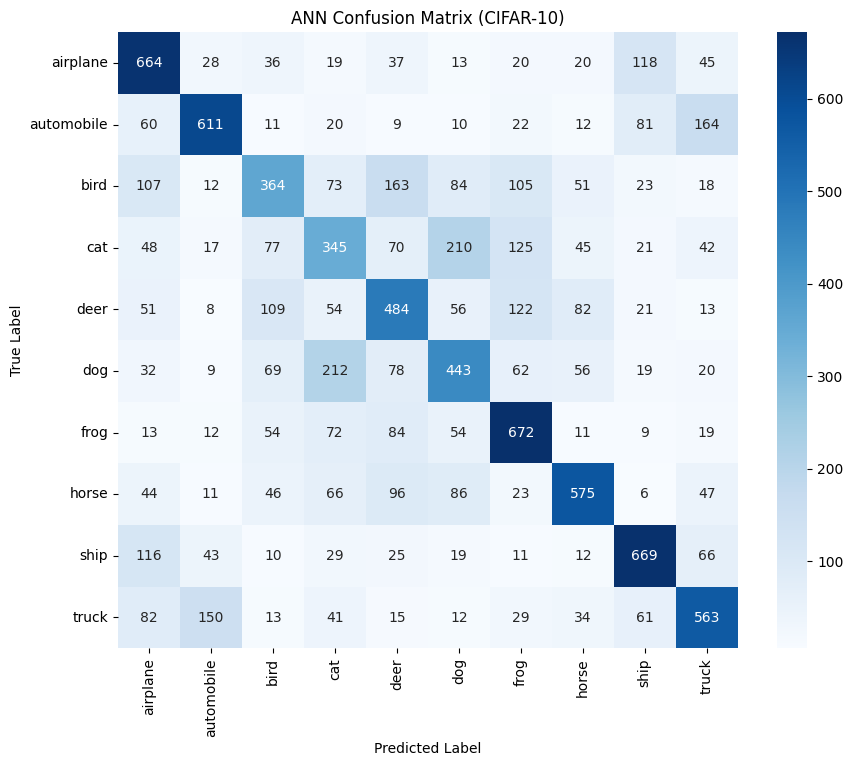


===== CNN Confusion Matrix (CIFAR-10) =====
Rows → True labels, Columns → Predicted labels

[[780  17  44  20  30  10   9  10  61  19]
 [ 14 871   6  12   4   9  12   0  35  37]
 [ 54   3 673  48  84  54  34  31  15   4]
 [ 18   6  81 516  74 170  58  39  29   9]
 [ 11   4  69  37 751  29  41  45  12   1]
 [ 10   2  50 132  51 684  19  38  11   3]
 [  3   3  61  44  35  31 805   6  12   0]
 [ 11   1  33  36  75  59   2 776   3   4]
 [ 37  24  20   6   5  14   1   2 885   6]
 [ 37  94  13  18   7  13   7  19  41 751]]


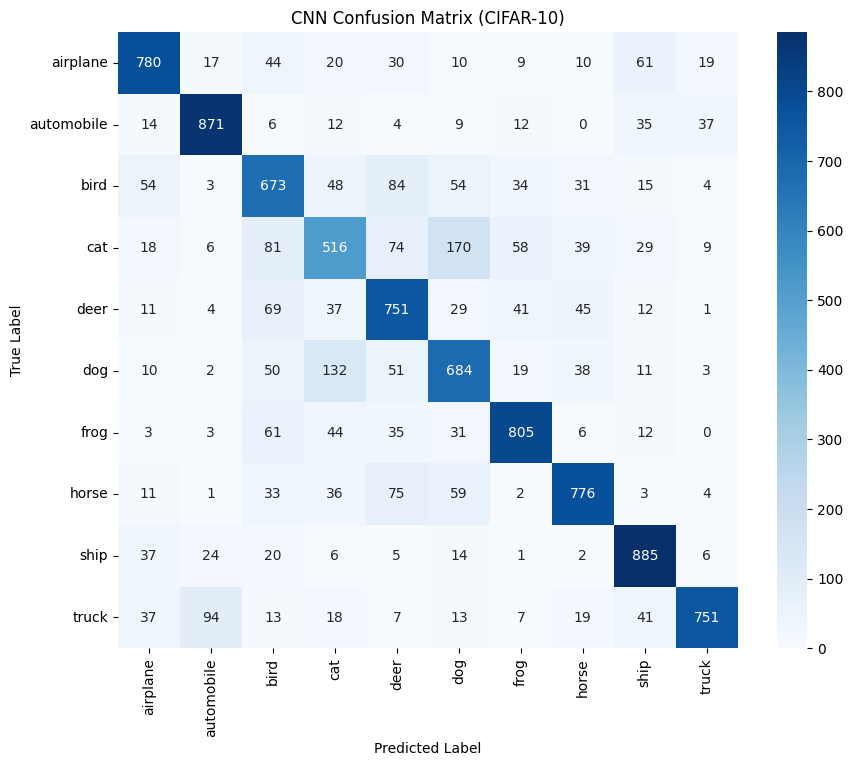

In [17]:
# Confusion matrix for ANN
cm_ann = plot_and_print_confusion_matrix(ann, test_loader, classes, title="ANN Confusion Matrix (CIFAR-10)")

# Confusion matrix for CNN
cm_cnn = plot_and_print_confusion_matrix(cnn, test_loader, classes, title="CNN Confusion Matrix (CIFAR-10)")


In [18]:
def show_sample_predictions(model, test_loader, classes, num_samples=8):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 4))

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Show num_samples images
            for i in range(num_samples):
                plt.subplot(2, num_samples//2, i+1)
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                img = (img * 0.5) + 0.5  # unnormalize
                plt.imshow(img)
                plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}",
                          color=("green" if preds[i]==labels[i] else "red"))
                plt.axis('off')
            break  # Only one batch needed
    plt.show()


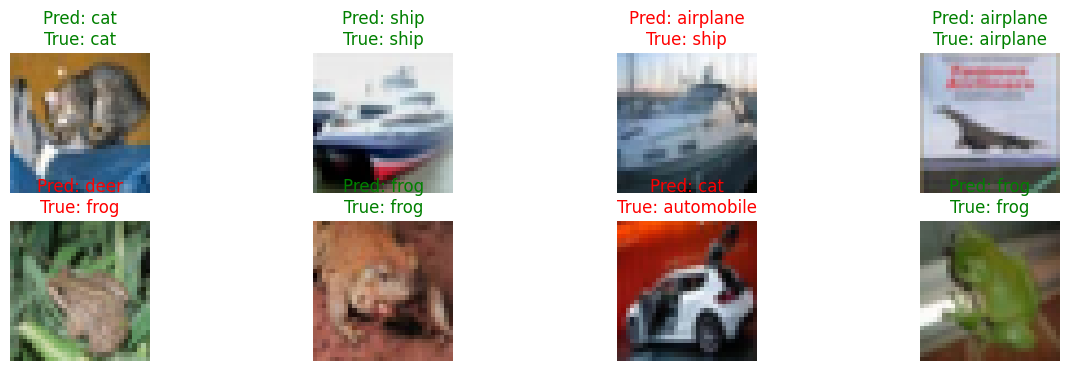

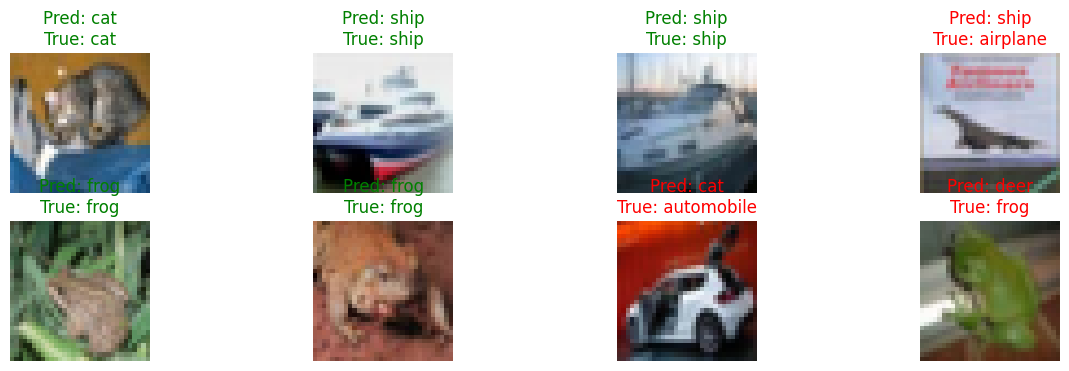

In [20]:
# ANN Confusion Matrix and Samples
show_sample_predictions(ann, test_loader, classes, num_samples=8)

# CNN Confusion Matrix and Samples
show_sample_predictions(cnn, test_loader, classes, num_samples=8)
